In [1]:
import pickle

# Load meta dict

with open('../../PNC/MegaMeta.bin', 'rb') as f:
    meta = pickle.load(f)
    
print(len(list(meta.keys())))

941


In [2]:
# only both emoid and nback

emoid_ts = []
nback_ts = []
wrat = []

for key in meta:
    if 'wrat' in meta[key]['meta']:
        if 'emoid' in meta[key] and 'badEmoid' not in meta[key] and 'nback' in meta[key] and 'badNback' not in meta[key]:
            wrat.append(int(meta[key]['meta']['wrat']['std']))
            nback_ts.append(meta[key]['nbackData'])
            emoid_ts.append(meta[key]['emoidData'])
        
print(len(wrat))
print(len(nback_ts))
print(len(emoid_ts))

620
620
620


In [3]:
# Make split

import numpy as np

nTrain = 550
perm = np.random.permutation(np.arange(len(emoid_ts)))
trainIdx = perm[:nTrain]
testIdx = perm[nTrain:]

with open('../../Work/DiffGraph/NbackEmoidSplit1.pkl', 'wb') as f:
    pickle.dump({'trainIdx': trainIdx, 'testIdx': testIdx}, f)
    
print('Complete')

Complete


In [4]:
import numpy as np

with open('../../Work/DiffGraph/NbackEmoidSplit1.pkl', 'rb') as f:
    dct = pickle.load(f)
    trainIdx = dct['trainIdx']
    testIdx = dct['testIdx']
    
nTrain = trainIdx.shape[0]
    
print(trainIdx.shape)
print(testIdx.shape)

(550,)
(70,)


In [5]:
import numpy as np
import torch
import math

nRoi = 264
alphaN = 3
alphaE = 3

nback_ts_t_A = [torch.from_numpy(np.concatenate([ts.T, alphaN*np.eye(nRoi)]))
               .float().cuda() for ts in nback_ts]
nback_ts_t_B = [torch.from_numpy(ts.T).float().cuda() for ts in nback_ts]

emoid_ts_t_A = [torch.from_numpy(np.concatenate([ts.T, alphaE*np.eye(nRoi)]))
               .float().cuda() for ts in emoid_ts]
emoid_ts_t_B = [torch.from_numpy(ts.T).float().cuda() for ts in emoid_ts]


wn = len(nback_ts)*[torch.zeros(nRoi,nRoi).float().cuda()]
we = len(emoid_ts)*[torch.zeros(nRoi,nRoi).float().cuda()]

prevErrN = math.inf
prevErrE = math.inf

for epoch in range(20):
    wMeanN = torch.mean(torch.stack(wn),axis=0)
    wMeanE = torch.mean(torch.stack(we),axis=0)
    errN = 0
    errE = 0
    for i in range(len(nback_ts)):
        if errN < prevErrN:
            A = nback_ts_t_A[i]
            B = torch.cat([nback_ts_t_B[i], wMeanN])
            wn[i],_,_,_ = torch.linalg.lstsq(A,B)
            errN += torch.sum(torch.abs(A@wn[i]-B))
        if errE < prevErrE:
            A = emoid_ts_t_A[i]
            B = torch.cat([emoid_ts_t_B[i], wMeanE])
            we[i],_,_,_ = torch.linalg.lstsq(A,B)
            errE += torch.sum(torch.abs(A@we[i]-B))
    if errN >= prevErrN and errE >= prevErrE:
        break
    prevErrN = errN
    prevErrE = errE
    print(f'Finished {epoch} errN={errN} errE={errE}')
    
print('Complete')

Finished 0 errN=2158169.75 errE=2055540.25
Finished 1 errN=2028165.75 errE=1931632.5
Finished 2 errN=2004590.5 errE=1909477.375
Finished 3 errN=1998831.75 errE=1904113.25
Finished 4 errN=1997296.125 errE=1902689.25
Finished 5 errN=1996868.125 errE=1902292.0
Finished 6 errN=1996745.5 errE=1902178.5
Finished 7 errN=1996709.25 errE=1902145.625
Finished 8 errN=1996700.75 errE=1902134.75
Finished 9 errN=1996698.0 errE=1902132.625
Finished 10 errN=1996696.875 errE=1902131.625
Finished 11 errN=1996696.5 errE=1902131.25
Complete


In [6]:
# Compute FC

import torch

# emoid_p_t = torch.from_numpy(np.stack([np.corrcoef(ts).flatten() for ts in emoid_ts])).float().cuda()
# nback_p_t = torch.from_numpy(np.stack([np.corrcoef(ts).flatten() for ts in nback_ts])).float().cuda()
emoid_p_t = torch.stack([w.flatten() for w in we])
nback_p_t = torch.stack([w.flatten() for w in wn])
wrat_t = torch.FloatTensor(wrat).cuda()

emoid_p_t_train = emoid_p_t[trainIdx]
nback_p_t_train = nback_p_t[trainIdx]
wrat_t_train = wrat_t[trainIdx]

emoid_p_t_test = emoid_p_t[testIdx]
nback_p_t_test = nback_p_t[testIdx]
wrat_t_test = wrat_t[testIdx]

print(emoid_p_t.shape)
print(nback_p_t.shape)
print(wrat_t.shape)
print(emoid_p_t_train.shape)
print(nback_p_t_train.shape)
print(wrat_t_train.shape)
print(emoid_p_t_test.shape)
print(nback_p_t_test.shape)
print(wrat_t_test.shape)

torch.Size([620, 69696])
torch.Size([620, 69696])
torch.Size([620])
torch.Size([550, 69696])
torch.Size([550, 69696])
torch.Size([550])
torch.Size([70, 69696])
torch.Size([70, 69696])
torch.Size([70])


In [7]:
w,_,_,_ = torch.linalg.lstsq(emoid_p_t_train,wrat_t_train)
pred = emoid_p_t_test@w
print(torch.mean(torch.abs(pred-wrat_t_test)))

tensor(10.1349, device='cuda:0')


tensor(13.9385, device='cuda:0')
tensor(10.1349, device='cuda:0')
[[1.         0.37745235]
 [0.37745235 1.        ]]


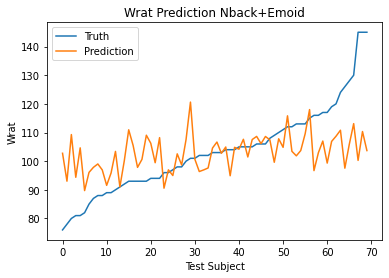

In [8]:
import matplotlib.pyplot as plt

py = pred.detach().cpu().numpy()
y = wrat_t_test.detach().cpu().numpy()
idcs = np.argsort(y)
y = y[idcs]
py = py[idcs]

rmse = torch.mean((pred-wrat_t_test)**2)**0.5
mae = torch.mean(torch.abs(pred-wrat_t_test))
corr = np.corrcoef(y,py)

print(rmse)
print(mae)
print(corr)

plt.plot(y, label='Truth')
plt.plot(py, label='Prediction')
plt.legend()
plt.title('Wrat Prediction Nback+Emoid')
plt.ylabel('Wrat')
plt.xlabel('Test Subject')
plt.show()

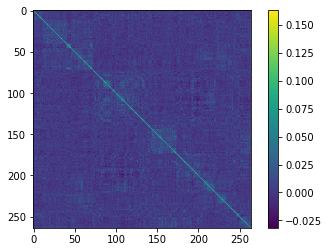

In [9]:
import matplotlib.pyplot as plt

plt.imshow(emoid_p_t_train[0].reshape(264,264).detach().cpu().numpy())
plt.colorbar()
plt.show()

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import itertools
import random
import copy

class ConGraph(nn.Module):
    def __init__(self):
        super(ConGraph, self).__init__()
        self.nn1 = nn.Linear(2*264*264,10).float().cuda()
        self.nn2 = nn.Linear(10,1).float().cuda()
        self.en1 = nn.Linear(2*264*264,10).float().cuda()
        self.en2 = nn.Linear(10,1).float().cuda()
        self.ee1 = nn.Linear(2*264*264,10).float().cuda()
        self.ee2 = nn.Linear(10,1).float().cuda()
        self.ens = nn.Linear(30,1).float().cuda()
        
    def forward(self, x):
        a1 = F.relu(self.nn1(torch.cat([x[0],x[2]],dim=1)))
        a2 = self.nn2(a1)
        b1 = F.relu(self.en1(torch.cat([x[1],x[2]],dim=1)))
        b2 = self.en2(b1)
        c1 = F.relu(self.ee1(torch.cat([x[1],x[3]],dim=1)))
        c2 = self.ee2(c1)
        x = self.ens(torch.cat([a1,b1,c1],dim=1))
        return a2,b2,c2,x
    
cg = ConGraph()
optim = torch.optim.Adam(cg.parameters(), lr=5e-4, weight_decay=0)

nEpoch = 10
bSize = 1000
pPeriod = 10000

pairs = list(itertools.combinations_with_replacement(np.arange(nTrain),2))

for i in range(nEpoch):
    randPairs = copy.copy(pairs)
    random.shuffle(randPairs)
    nComplete = 0
    print(f'epoch {i}')
    while nComplete < len(pairs):
        todo = len(pairs)-nComplete
        if todo > bSize:
            todo = bSize
        batchPairs = randPairs[nComplete:nComplete+todo]
        Ai, Bi = zip(*batchPairs)
        A1 = nback_p_t_train[Ai,:]
        A2 = emoid_p_t_train[Ai,:]
        B1 = nback_p_t_train[Bi,:]
        B2 = emoid_p_t_train[Bi,:]
        a = wrat_t_train[list(Ai)]
        b = wrat_t_train[list(Bi)]
        optim.zero_grad()
        pos = [A1,A2,B1,B2]
        neg = [B1,B2,A1,A2]
        prA,prB,prC,pr = cg(pos)
        nrA,nrB,nrC,nr = cg(neg)
        pp = ((prA+prB+prC+pr)/4).flatten()
        nn = ((nrA+nrB+nrC+nr)/4).flatten()
        posLoss = torch.mean((pp-(a-b))**2)**0.5
        negLoss = torch.mean((nn-(b-a))**2)**0.5
        (posLoss+negLoss).backward()
        optim.step()
        if nComplete % pPeriod == 0:
            print(f'\tposLoss={posLoss} negLoss={negLoss}')
        nComplete += todo
        if posLoss < 0.05:
            break
    if posLoss < 0.05:
        break
        
print('Complete')

epoch 0
	posLoss=21.31769561767578 negLoss=21.316944122314453
	posLoss=22.23857879638672 negLoss=22.23923110961914
	posLoss=22.211036682128906 negLoss=22.21735954284668
	posLoss=21.890478134155273 negLoss=21.89510154724121
	posLoss=21.76582908630371 negLoss=21.786218643188477
	posLoss=22.348806381225586 negLoss=22.3642635345459
	posLoss=21.777280807495117 negLoss=21.77153205871582
	posLoss=21.146339416503906 negLoss=21.157560348510742
	posLoss=21.480669021606445 negLoss=21.47384262084961
	posLoss=21.6635799407959 negLoss=21.66588020324707
	posLoss=19.310546875 negLoss=19.309356689453125
	posLoss=20.226598739624023 negLoss=20.2215518951416
	posLoss=19.796279907226562 negLoss=19.810518264770508
	posLoss=19.45981216430664 negLoss=19.469236373901367
	posLoss=19.45158576965332 negLoss=19.47936248779297
	posLoss=18.759357452392578 negLoss=18.7972412109375
epoch 1
	posLoss=18.341306686401367 negLoss=18.351083755493164
	posLoss=18.566757202148438 negLoss=18.576505661010742
	posLoss=17.42076110

done 0
done 20
done 40
done 60
Positive
[[1.         0.45329968]
 [0.45329968 1.        ]]
13.45971757882783
9.885013907296317
Negative
[[1.         0.43301688]
 [0.43301688 1.        ]]
13.598945072029553
10.034372275216239
Mean
[[1.         0.44879365]
 [0.44879365 1.        ]]
13.492548555245166
9.959040451049805
Least squares
[[1.         0.37863088]
 [0.37863088 1.        ]]
13.958037021205795
10.188692


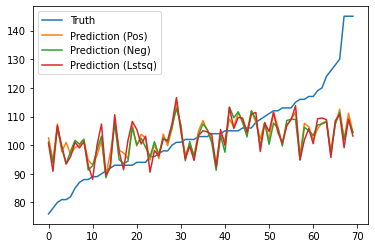

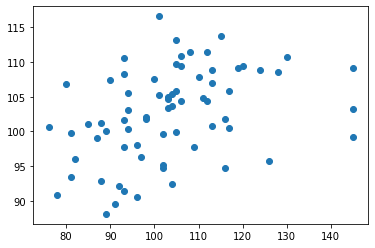

In [11]:
# Test

import matplotlib.pyplot as plt

wp = np.zeros(len(testIdx))
wn = np.zeros(len(testIdx))

for i in range(nback_p_t_test.shape[0]):
    if i % 20 == 0:
        print(f'done {i}')
        
    A1 = nback_p_t_test[i].expand(nTrain,-1)
    A2 = emoid_p_t_test[i].expand(nTrain,-1)
    a = wrat_t_test[i].expand(nTrain)

    B1 = nback_p_t_train
    B2 = emoid_p_t_train
    b = wrat_t_train

    pos = [A1,A2,B1,B2]
    neg = [B1,B2,A1,A2]
    p1,p2,p3,posRes = cg(pos)
    n1,n2,n3,negRes = cg(neg)
    
    posRes = ((p1+p2+p3+posRes)/4).flatten()
    negRes = ((n1+n2+n3+negRes)/4).flatten()

    wratPos = posRes + b
    wratNeg = b - negRes

    wp[i] = torch.mean(wratPos).detach().cpu().numpy()
    wn[i] = torch.mean(wratNeg).detach().cpu().numpy()

# pred = gat(rest_ts_t_test)
# pred = pred.flatten().detach().cpu().numpy()
y = wrat_t_test.detach().cpu().numpy()

idcs = np.argsort(y)
wp = wp[idcs]
wn = wn[idcs]
wm = (wp+wn)/2
y = y[idcs]

print('Positive')

corr = np.corrcoef(y, wp)
rmse = np.mean((y-wp)**2)**0.5
mae = np.mean(np.abs(y-wp))

print(corr)
print(rmse)
print(mae)

print('Negative')

corr = np.corrcoef(y, wn)
rmse = np.mean((y-wn)**2)**0.5
mae = np.mean(np.abs(y-wn))

print(corr)
print(rmse)
print(mae)

print('Mean')

corr = np.corrcoef(y, wm)
rmse = np.mean((y-wm)**2)**0.5
mae = np.mean(np.abs(y-wm))

print(corr)
print(rmse)
print(mae)

w,_,_,_ = torch.linalg.lstsq(torch.cat([nback_p_t_train,emoid_p_t_train],dim=1),wrat_t_train)

a = torch.cat([nback_p_t_test,emoid_p_t_test],dim=1)@w
a = a.detach().cpu().numpy()
y = wrat_t_test.detach().cpu().numpy()

idcs = np.argsort(y)
a = a[idcs]
y = y[idcs]

print('Least squares')

corr = np.corrcoef(y, a)
rmse = np.mean((y-a)**2)**0.5
mae = np.mean(np.abs(y-a))

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(wp, label='Prediction (Pos)')
plt.plot(wn, label='Prediction (Neg)')
plt.plot(a, label='Prediction (Lstsq)')
plt.legend()
plt.show()

plt.scatter(y, a)
plt.show()